# A2Perf Metric Analysis


### Imports

In [1]:
!pip install tensorboard sns tbparse matplotlib pandas scipy

In [2]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorboard as tb
from packaging import version
from scipy import stats
from tbparse import SummaryReader

In [3]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.14.1


## PPO

### Reliability Metrics
****

In [ ]:
base_dir = '/home/ikechukwuu/workspace/gcs/a2perf/'
debug=False
algo_to_exp_dict={'ppo': '0001 ', 'ddpg': '0004'}

#### Get all the logs

In [5]:
log_dirs = glob.glob(os.path.join(base_dir, experiment_number, f'**/tensorboard/PPO_0_1/*events*'), recursive=True)
log_dirs

['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0001/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1696304337.locomotion-2',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0001/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1696304298.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0001/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_82_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1696304327.locomotion-1']

In [6]:
all_df = pd.DataFrame()
for log_dir in log_dirs:
    reader = SummaryReader(log_dir)

    df = reader.scalars

    # label each row with the random seed
    df['seed'] = log_dir.split('/')[-4].split('_')[-5]
    print(f'Seed: {df["seed"].iloc[0]}')

    # label each row with the experiment number
    df['experiment'] = log_dir.split('/')[-6]

    print(f'Finished processing {log_dir}')
    print(f'Number of rows: {len(df)}')

    # Print out the last global step value
    print(f'Last global step value: {df["step"].iloc[-1]}')
    all_df = pd.concat([all_df, df])


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


Seed: 14
Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0001/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1696304337.locomotion-2
Number of rows: 6294312
Last global step value: 199996505


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


Seed: 37
Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0001/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1696304298.locomotion-0
Number of rows: 6294514
Last global step value: 199996505


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


Seed: 82
Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0001/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_82_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1696304327.locomotion-1
Number of rows: 6294565
Last global step value: 199996505


In [9]:

ep_rew_df = all_df[all_df['tag'] == 'episode_reward']
ep_rew_df.head()

,step,tag,value,seed,experiment
0,14,episode_reward,0.955002,14,ppo
1,4251,episode_reward,0.866052,14,ppo
2,4271,episode_reward,1.319138,14,ppo
3,8516,episode_reward,1.264436,14,ppo
4,12751,episode_reward,1.196567,14,ppo


In [10]:
# Using all_df we can print out the eval points used for reliability metrics across runs
# print out common step values between each seed
seed_grouped = ep_rew_df.groupby('seed')
for seed, group in seed_grouped:
    print(f'Seed: {seed}')
    print(group['step'].unique().shape)

Seed: 14
(35465,)
Seed: 37
(35667,)
Seed: 82
(35718,)


In [11]:
# Get all the steps/values that are duplicated
for seed, group in seed_grouped:
    print(f'Seed: {seed}')
    duplicated_indices = group['step'].duplicated()
    duplicated_steps = group['step'][duplicated_indices]
    print(f'Ratio of duplicated steps: {len(duplicated_steps) / len(group)}')

    # Group by the step so we can see how many times duplicated steps occur
    duplicated_grouped = group.groupby('step')
    print('Number of times each duplicated step occurs')

    # print total number of duplicates but we have to subtract 1 because the first occurence is not a duplicate
    print((duplicated_grouped.size() - 1).sum())

Seed: 14
Ratio of duplicated steps: 0.0
Number of times each duplicated step occurs
0
Seed: 37
Ratio of duplicated steps: 0.0
Number of times each duplicated step occurs
0
Seed: 82
Ratio of duplicated steps: 0.0
Number of times each duplicated step occurs
0


In [12]:
# What are the unique tags?
tags = all_df['tag'].unique()
tags

array(['episode_reward', 'episodes/episodes_in_batch',
       'input_info/advantage', 'input_info/clip_range',
       'input_info/discounted_rewards', 'input_info/learning_rate',
       'loss/approximate_kullback-leibler', 'loss/clip_factor',
       'loss/clip_frac', 'loss/entropy_loss', 'loss/loss',
       'loss/policy_gradient_loss', 'loss/value_function_loss'],
      dtype=object)

In [13]:
# Sometimes the gap between steps is not uniform.
# Reliability metrics implementation should take this into account by supplying a list of eval points along with the window size
for seed, group in seed_grouped:
    print(f'Seed: {seed}')
    diff = group['step'].diff()
    print(diff.describe())



Seed: 14
count    35464.000000
mean      5639.423077
std       2303.224933
min          9.000000
25%       4252.000000
50%       4258.000000
75%       8484.000000
max      17010.000000
Name: step, dtype: float64
Number of rows before filtering: 35465
Number of rows after filtering: 34771
(34771,)
Seed: 37
count    35666.000000
mean      5607.483458
std       2276.304551
min         11.000000
25%       4252.000000
50%       4257.000000
75%       8483.000000
max      17010.000000
Name: step, dtype: float64
Number of rows before filtering: 35667
Number of rows after filtering: 35002
(35002,)
Seed: 82
count    35717.000000
mean      5599.357309
std       2299.435127
min         12.000000
25%       4252.000000
50%       4257.000000
75%       8483.000000
max      21249.000000
Name: step, dtype: float64
Number of rows before filtering: 35718
Number of rows after filtering: 35013
(35013,)


In [51]:
# For plotting let's remove them though
# For each group, filter out the rows where the step difference is less than 1000
# Save in a new dataframe
ep_rew_clean = pd.DataFrame()
for seed, group in seed_grouped:
    print(f'Seed: {seed}')
    diff = group['step'].diff()
    print(diff.describe())
    print(f'Number of rows before filtering: {len(group)}')
    group = group[diff > 1000]
    print(f'Number of rows after filtering: {len(group)}')
    print(group['step'].unique().shape)
    ep_rew_clean = pd.concat([ep_rew_clean, group])

,step,value
count,1.047860e+05,104786.000000
mean,9.643360e+07,14.005950
std,5.823015e+07,5.454134
min,4.251000e+03,0.633976
25%,4.552708e+07,10.665405
50%,9.515326e+07,13.405523
75%,1.464890e+08,16.797892
max,1.999965e+08,64.419540


<Axes: xlabel='step', ylabel='value'>

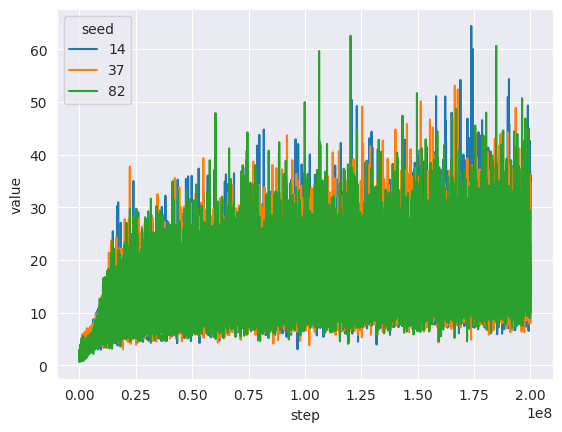

In [52]:
ep_rew_clean.describe()

<Axes: xlabel='step', ylabel='value'>

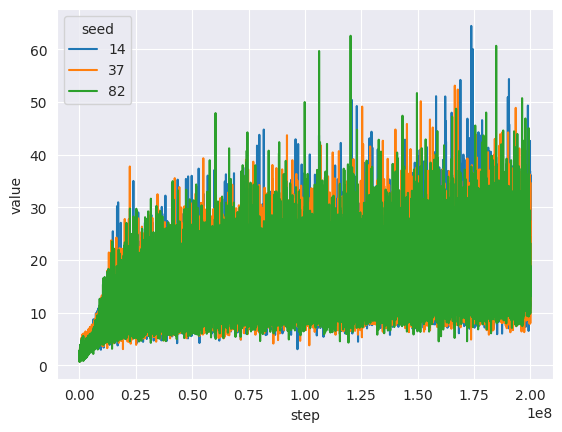

In [53]:
# plot the episode reward, but use random seeds for shading
sns.lineplot(data=ep_rew_df, x='step', y='value', hue='seed')

In [14]:
sns.lineplot(data=ep_rew_clean, x='step', y='value', hue='seed')

In [15]:
# How many eval points do the seeds have in common?
# For each seed, get the unique eval points
# Then get the intersection of all the unique eval points

seed_grouped_clean = ep_rew_clean.groupby('seed')

,step,tag,value,seed,experiment
1,4251,episode_reward,0.866052,14,ppo
3,8516,episode_reward,1.264436,14,ppo
4,12751,episode_reward,1.196567,14,ppo
6,17015,episode_reward,1.611842,14,ppo
7,21252,episode_reward,1.404741,14,ppo
1,4264,episode_reward,1.202941,37,ppo
2,8509,episode_reward,2.298799,37,ppo
3,12753,episode_reward,0.847035,37,ppo
5,17018,episode_reward,1.172897,37,ppo
6,21263,episode_reward,1.161709,37,ppo


In [56]:
seed_grouped_clean.head()

Number of eval points in common: 33


{10973513,
 17306020,
 23026505,
 26256512,
 29235763,
 29435513,
 31025008,
 31042018,
 33090511,
 33349771,
 34684258,
 35126255,
 36613768,
 40366514,
 41089013,
 53456515,
 55169262,
 61654753,
 76640263,
 84808762,
 89891768,
 94796266,
 99951505,
 111460516,
 125919002,
 128894005,
 129055501,
 138681750,
 140683502,
 152001252,
 164687513,
 176162513,
 184683771}

In [59]:
# List of sets, each set containing unique 'steps' for each random seed
sets_of_steps = [set(group['step'].values) for _, group in seed_grouped_clean]

# Compute intersection of all sets
intersection_of_steps = set.intersection(*sets_of_steps)
print(f'Number of eval points in common: {len(intersection_of_steps)}')

Number of eval points in common: 0


### Computing Window Size

<Axes: xlabel='step', ylabel='value'>

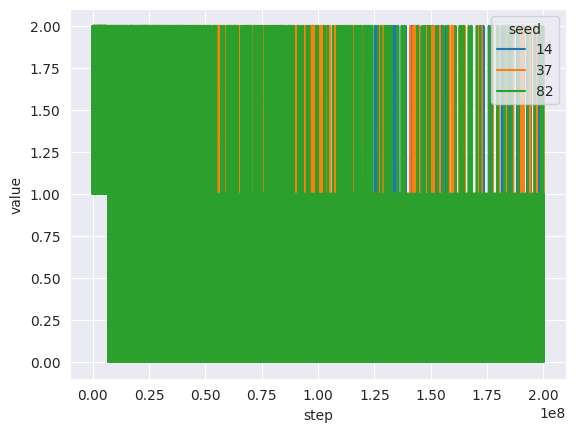

In [17]:
# Window size should approximately be large enough to capture five eval points
# Therefore, we set the window size to be 5 * avg(step difference)

mean_step_diff = ep_rew_clean['step'].diff().mean()
median_step_diff = ep_rew_clean['step'].diff().median()
EVAL_POINTS_PER_WINDOW = 5
window_size = int((EVAL_POINTS_PER_WINDOW - 1) * median_step_diff)

print(f'Mean step difference: {mean_step_diff}')
print(f'Median step difference: {median_step_diff}')
print(f'Window size: {window_size}')

<Axes: xlabel='step', ylabel='value'>

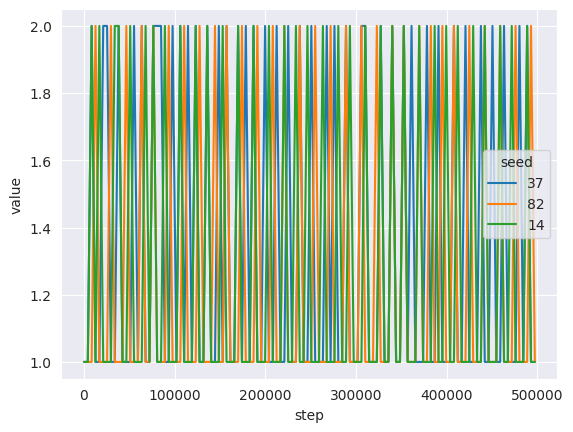

In [121]:
# How many episodes are in each eval point
all_df[all_df['tag'] == 'episodes/episodes_in_batch'].describe()

# Plot the episodes in batch
sns.lineplot(data=all_df[all_df['tag'] == 'episodes/episodes_in_batch'], x='step', y='value', hue='seed')

#### Computing Reliability Metrics

In [164]:
curves = ep_rew_df.groupby('seed')
eval_points = list(
    range(int((EVAL_POINTS_PER_WINDOW / 2 + 1) * median_step_diff), max(ep_rew_df['step']), int(median_step_diff)))
eval_points

[14857,
 19102,
 23347,
 27592,
 31837,
 36082,
 40327,
 44572,
 48817,
 53062,
 57307,
 61552,
 65797,
 70042,
 74287,
 78532,
 82777,
 87022,
 91267,
 95512,
 99757,
 104002,
 108247,
 112492,
 116737,
 120982,
 125227,
 129472,
 133717,
 137962,
 142207,
 146452,
 150697,
 154942,
 159187,
 163432,
 167677,
 171922,
 176167,
 180412,
 184657,
 188902,
 193147,
 197392,
 201637,
 205882,
 210127,
 214372,
 218617,
 222862,
 227107,
 231352,
 235597,
 239842,
 244087,
 248332,
 252577,
 256822,
 261067,
 265312,
 269557,
 273802,
 278047,
 282292,
 286537,
 290782,
 295027,
 299272,
 303517,
 307762,
 312007,
 316252,
 320497,
 324742,
 328987,
 333232,
 337477,
 341722,
 345967,
 350212,
 354457,
 358702,
 362947,
 367192,
 371437,
 375682,
 379927,
 384172,
 388417,
 392662,
 396907,
 401152,
 405397,
 409642,
 413887,
 418132,
 422377,
 426622,
 430867,
 435112,
 439357,
 443602,
 447847,
 452092,
 456337,
 460582,
 464827,
 469072,
 473317,
 477562,
 481807,
 486052,
 490297,
 494

##### Dispersion within runs

In [20]:
window_fn = stats.iqr
all_mean_iqr_values = []
mean_iqr_values = []
number_valid_eval_points = []
for seed, group in seed_grouped_clean:
    print(f'Processing seed: {seed}')
    windows_to_evaluate = []
    iqr_values = []

    # Sort the group by step
    group = group.sort_values(by='step')

    # Get the step-by-step difference
    group['episode_reward_diff'] = group['value'].diff()

    for eval_point in eval_points:
        low_end = eval_point - (window_size / 2)
        high_end = eval_point + (window_size / 2)

        # print(f'Eval point: {eval_point}')
        eval_points_above = group['step'] >= low_end
        eval_points_below = group['step'] <= high_end
        valid_eval_point_loc = eval_points_above & eval_points_below
        valid_eval_points = group[valid_eval_point_loc]

        number_valid_eval_points.append(len(valid_eval_points))
        if len(valid_eval_points) == 0:
            raise ValueError(f'No valid eval points for eval point: {eval_point}')
        windows_to_evaluate.append(valid_eval_points)

    # Use numpy to quickly apply the window function to each window in our list
    iqr_values = [window_fn(window['episode_reward_diff']) for window in windows_to_evaluate]
    mean_iqr = np.mean(iqr_values)
    median_iqr = np.median(iqr_values)
    print(f'On average there were {np.mean(number_valid_eval_points)} valid eval points per window')
    print(f'Mean IQR: {mean_iqr}')
    print(f'Median IQR: {median_iqr}')

    all_mean_iqr_values.append(mean_iqr)

# Finally, report the mean and standard deviation of ALL the mean iqr values in \pm notation
print(f'All mean iqr values: {all_mean_iqr_values}')
print(f'Average mean iqr value: {np.mean(all_mean_iqr_values)} +/- {np.std(all_mean_iqr_values)}')



##### Long-term risk across time
Long-term risk across time represents the propensity of the agent to crash after achieving a higher performance measure
 

In [21]:
def compute_drawdown(sequence):
    """Computes the drawdown for a sequence of numbers.

      The drawdown at time T is the decline from the highest peak occurring at or
      before time T. https://en.wikipedia.org/wiki/Drawdown_(economics).

      The drawdown is always non-negative. A larger (more positive) drawdown
      indicates a larger drop.

    Args:
      sequence: A numpy array.

    Returns:
      A numpy array of same length as the original sequence, containing the
        drawdown at each timestep.
    """
    peak_so_far = np.maximum.accumulate(sequence)
    return peak_so_far - sequence

In [22]:
alpha = 0.05

all_cvars = []
for seed, group in seed_grouped_clean:
    print(f'Processing seed: {seed}')

    # Sort the group by step
    group = group.sort_values(by='step')

    # Compute the drawdowns
    episode_rewards = group['value'].values
    drawdowns = compute_drawdown(episode_rewards)

    # Get the bottom "alpha" percent of drawdowns
    bottom_alpha_percent = np.percentile(drawdowns, alpha * 100)

    # CVaR is the average of the bottom "alpha" percent of drawdowns
    cvar = np.mean(drawdowns[drawdowns <= bottom_alpha_percent])

    all_cvars.append(cvar)
    print(f'CVaR: {cvar}')

# Finally, report the mean and standard deviation of ALL the CVaR values in \pm notation
print(f'All CVaR values: {all_cvars}')
print(f'Average CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')


Processing seed: 14
CVaR: 1.522775846250171
Processing seed: 37
CVaR: 1.6745595947665395
Processing seed: 82
CVaR: 1.9256382421518583
All CVaR values: [1.522775846250171, 1.6745595947665395, 1.9256382421518583]
Average CVaR value: 1.7076578943895229 +/- 0.1661247534964041



##### Short-term risk across time
Short-term risk across time represents how volatile the agent is from eval point to eval point


In [199]:
alpha = 0.05
all_cvars = []
for seed, group in seed_grouped_clean:
    print(f'Processing seed: {seed}')

    # Sort the group by step
    group = group.sort_values(by='step')

    # Compute the diffs
    episode_rewards = group['value'].values
    episode_rewards_diff = np.diff(episode_rewards)

    # Get the bottom "alpha" percent of diffs
    bottom_alpha_percent = np.percentile(drawdowns, alpha * 100)

    # CVaR is the average of the bottom "alpha" percent of diffs
    cvar = np.mean(drawdowns[drawdowns <= bottom_alpha_percent])

    all_cvars.append(cvar)
    print(f'CVaR: {cvar}')

# Finally, report the mean and standard deviation of ALL the CVaR values in \pm notation
print(f'All CVaR values: {all_cvars}')
print(f'Average CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')


Processing seed: 14
CVaR: 0.0032287041346232095
Processing seed: 37
CVaR: 0.0032287041346232095
Processing seed: 82
CVaR: 0.0032287041346232095
All CVaR values: [0.0032287041346232095, 0.0032287041346232095, 0.0032287041346232095]
Average CVaR value: 0.0032287041346232095 +/- 0.0



##### Risk across runs

In [205]:
# Get the final episode reward for each seed
final_episode_rewards = ep_rew_clean.groupby('seed').tail(1)
print(f'Final episode rewards: {final_episode_rewards["value"].values}')

# Compute the CVaR of the final episode rewards
alpha = 0.05
bottom_alpha_percent = np.percentile(final_episode_rewards['value'].values, alpha * 100, interpolation='linear')
cvar = np.mean(final_episode_rewards['value'].values[final_episode_rewards['value'].values <= bottom_alpha_percent])
print(f'CVaR: {cvar}')

Final episode rewards: [1.25840461 2.6807375  2.3252306 ]
CVaR: 1.2584046125411987


#### Dispersion across runs

In [229]:
def lowpass_filter(curve, lowpass_thresh):
    filt_b, filt_a = scipy.signal.butter(8, lowpass_thresh)

    def butter_filter_fn(c):
        padlen = min(len(c) - 1, 3 * max(len(filt_a), len(filt_b)))
        return scipy.signal.filtfilt(filt_b, filt_a, curve, padlen=padlen)

    processed_curve = butter_filter_fn(curve)
    return processed_curve

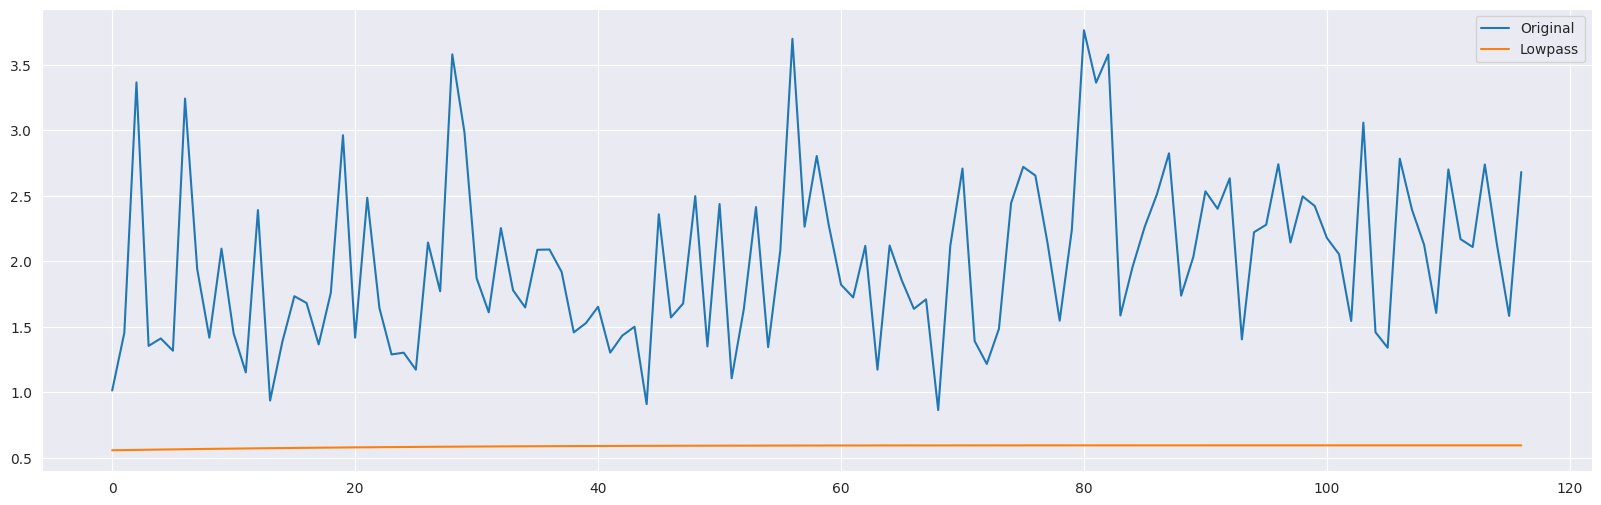

In [242]:
# Plot the first curve before and after lowpass filtering
curve = ep_rew_clean[ep_rew_clean['seed'] == '37']['value'].values
lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)

plt.figure(figsize=(20, 6))  # Adjust the size as needed
plt.plot(curve, label='Original')
plt.plot(lowpass_curve, label='Lowpass')
plt.legend()

# Let's store the lowpass filtered curves in a new dataframe
ep_rew_clean['lowpass_value'] = ep_rew_clean.groupby('seed')['value'].transform(
    lambda x: lowpass_filter(x, low_pass_thresh))

In [253]:
# For dispersion across runs, we use a similar concept as the one used for dispersion within runs
window_size = 4096  # this window size is a little different because we just need to capture a single value close to the designated eval point
low_pass_thresh = 0.01

# Group by seed, then get intersection of steps between seeds
seed_steps_sets = seed_grouped_clean['step'].apply(set)
common_steps = set.intersection(*seed_steps_sets)

print(f'Number of common steps: {len(common_steps)}')

Number of common steps: 0


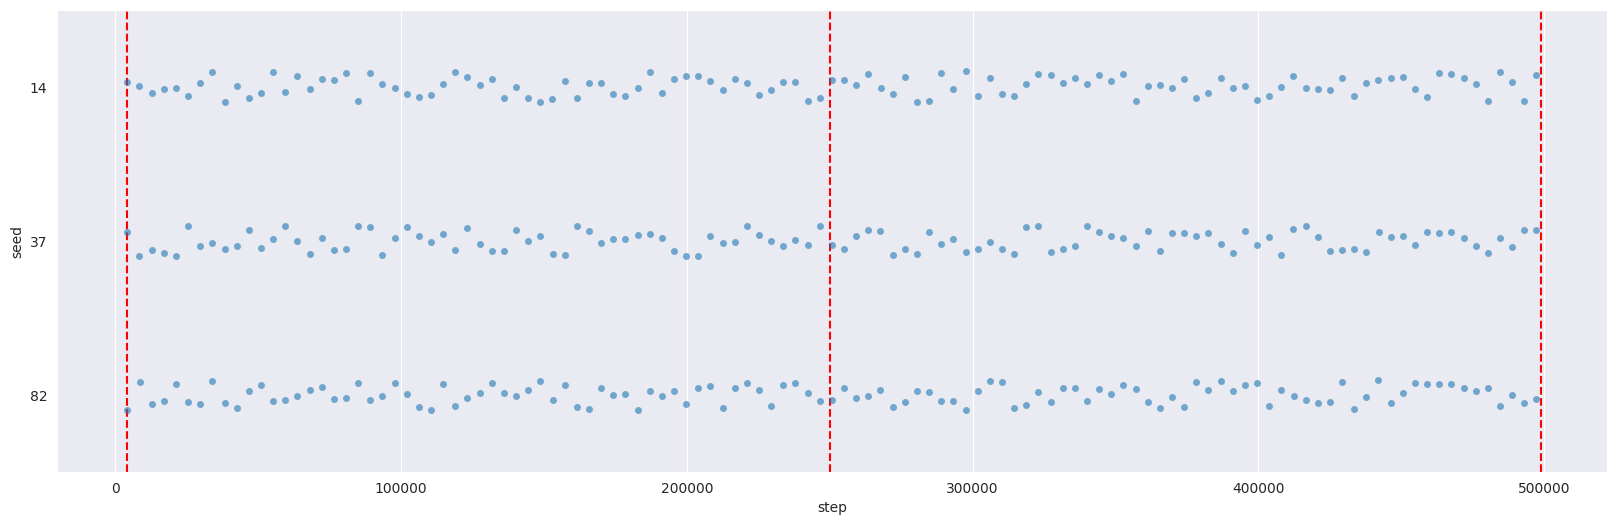

In [260]:
# Let's do the same plot, but draw vertical red lines at the eval points. We'll choose the eval points for dispersion across runs by hand, then automatically select the points in the plot closest to the eval points
plt.figure(figsize=(20, 6))  # Adjust the size as needed

# Plot the distribution of steps across seeds
fig = sns.stripplot(data=ep_rew_clean, x='step', y='seed', jitter=True, marker='o', alpha=0.6)

EVAL_POINTS = [4096, 250000, 499000]
for eval_point in EVAL_POINTS:
    # Draw the vertical red line at eval_point
    fig.axvline(eval_point, color='red', linestyle='--')

In [261]:
# For each seed, get the closest step to the eval points within the window size
DISPERSION_ACROSS_RUNS_WINDOW_SIZE = 4096

# For each seed, get the closest step to the eval points within the window size
all_closest_values = []
for seed, group in seed_grouped_clean:
    print(f'Processing seed: {seed}')
    group = group.sort_values(by='step')

    # Get the closest step to the eval points within the window size
    closest_values = []
    for eval_point in EVAL_POINTS:

        # If the curve has a step that is equal to the eval point, then we don't need to do anything
        if eval_point in group['step'].values:
            closest_values.append(group[group['step'] == eval_point]['value'].values[0])
            continue

        # Find the closest step to the eval point
        low_end = eval_point - (DISPERSION_ACROSS_RUNS_WINDOW_SIZE / 2)
        high_end = eval_point + (DISPERSION_ACROSS_RUNS_WINDOW_SIZE / 2)

        valid_eval_points = group[(group['step'] >= low_end) & (group['step'] <= high_end)]

        if len(valid_eval_points) == 0:
            raise ValueError(f'No valid eval points for eval point: {eval_point}')

        # Get the closest step to the eval point
        closest_step_index = (valid_eval_points['step'] - eval_point).abs().idxmin()
        closest_step = valid_eval_points.loc[closest_step_index]
        print(f'Closest step: {closest_step.step}')
        closest_values.append(closest_step.value)
    all_closest_values.append(closest_values)

all_closest_values = np.array(all_closest_values)


Processing seed: 14
Closest step: 4264
Closest step: 250769
Closest step: 497256
Processing seed: 37
Closest step: 4258
Closest step: 250753
Closest step: 497261
Processing seed: 82
Closest step: 4264
Closest step: 250757
Closest step: 497266
All closest values: [[1.34441721 0.71191138 1.25840461]
 [1.01246238 2.8034687  2.6807375 ]
 [2.46645665 2.53051519 2.3252306 ]]


In [262]:
all_closest_values

array([[1.34441721, 0.71191138, 1.25840461],
       [1.01246238, 2.8034687 , 2.6807375 ],
       [2.46645665, 2.53051519, 2.3252306 ]])

In [263]:
# Compute the IQR of the closest values
iqr_values = stats.iqr(all_closest_values, axis=0)
iqr_values

array([0.72699714, 1.04577866, 0.71116644])

In [ ]:
# Report the average of this 


### System Metrics
****


In [42]:
log_dirs = glob.glob(os.path.join(base_dir, experiment_number, f'**/metrics/train_emissions.csv'), recursive=True)
log_dirs

['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/debug/dog_pace/ppo/0007/quadruped_locomotion_int_save_freq_100000_parallel_cores_170_seed_37_total_env_steps_500000/metrics/train_emissions.csv',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/debug/dog_pace/ppo/0007/quadruped_locomotion_int_save_freq_100000_parallel_cores_170_seed_82_total_env_steps_500000/metrics/train_emissions.csv',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/debug/dog_pace/ppo/0007/quadruped_locomotion_int_save_freq_100000_parallel_cores_170_seed_14_total_env_steps_500000/metrics/train_emissions.csv']

In [52]:
system_df = pd.DataFrame()
for log_dir in log_dirs:
    df = pd.read_csv(log_dir)
    seed = log_dir.split('/')[-3].split('_')[-5]
    experiment = log_dir.split('/')[-5]

    # Create new columns for seed and experiment
    df['seed'] = seed
    df['experiment'] = experiment

    system_df = pd.concat([system_df, df])

In [53]:
system_df.describe()

,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,gpu_energy,ram_energy,energy_consumed,region,cloud_provider,cloud_region,cpu_count,gpu_count,gpu_model,longitude,latitude,ram_total_size,ram_process
count,39.000000,39.000000,3.900000e+01,39.0,39.0,39.000000,39.000000,39.0,39.000000,39.000000,0.0,0.0,0.0,39.0,39.0,0.0,0.0,0.0,39.000000,39.000000
mean,70.303656,0.001215,1.722996e-05,120.0,0.0,44.728890,0.002343,0.0,0.000918,0.003262,NaN,NaN,NaN,360.0,0.0,NaN,NaN,NaN,1417.290159,119.281437
std,37.694788,0.000655,1.304665e-07,0.0,0.0,13.135082,0.001256,0.0,0.000502,0.001758,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000019,35.027526
min,10.061439,0.000172,1.695560e-05,120.0,0.0,0.107517,0.000335,0.0,0.000126,0.000462,NaN,NaN,NaN,360.0,0.0,NaN,NaN,NaN,1417.290138,0.286713
25%,40.225353,0.000689,1.709913e-05,120.0,0.0,46.330065,0.001341,0.0,0.000509,0.001849,NaN,NaN,NaN,360.0,0.0,NaN,NaN,NaN,1417.290138,123.559872
50%,70.287997,0.001216,1.727578e-05,120.0,0.0,49.370592,0.002343,0.0,0.000921,0.003264,NaN,NaN,NaN,360.0,0.0,NaN,NaN,NaN,1417.290157,131.654911
75%,100.600663,0.001747,1.734296e-05,120.0,0.0,49.406918,0.003353,0.0,0.001335,0.004688,NaN,NaN,NaN,360.0,0.0,NaN,NaN,NaN,1417.290184,131.751879
max,133.499627,0.002303,1.738282e-05,120.0,0.0,49.428532,0.004450,0.0,0.001733,0.006182,NaN,NaN,NaN,360.0,0.0,NaN,NaN,NaN,1417.290184,131.809418


In [57]:
power_df = system_df.groupby(['seed'])[system_df.columns[system_df.columns.str.contains('power')]]
power_df

In [55]:
power_df.head()

AttributeError: 'Index' object has no attribute 'head'

In [49]:
power_df.head()

,cpu_power,gpu_power,ram_power
0,120.0,0.0,45.394964
1,120.0,0.0,45.733492
2,120.0,0.0,46.383309
3,120.0,0.0,49.211201
4,120.0,0.0,49.357279


In [46]:
power_df.groupby('seed').head()

,cpu_power,gpu_power,ram_power,seed,experiment
0,120.0,0.0,45.394964,37,ppo
1,120.0,0.0,45.733492,37,ppo
2,120.0,0.0,46.383309,37,ppo
3,120.0,0.0,49.211201,37,ppo
4,120.0,0.0,49.357279,37,ppo
0,120.0,0.0,45.429420,82,ppo
1,120.0,0.0,45.770245,82,ppo
2,120.0,0.0,46.276822,82,ppo
3,120.0,0.0,49.214808,82,ppo
4,120.0,0.0,49.337897,82,ppo


In [47]:
# Get average power usage for each seed
power = power_df.groupby(['seed'])
cpu_power = power_df.filter(regex='cpu_power').groupby(['seed'])

KeyError: 'seed'

In [68]:
# Get average duration for each seed. Duration is cumulative, so we need to get the final value for each seed
durations = duration_df.groupby(['seed']).tail(1)
# pretty print average plusor minus standard deviation in hours
print(f'Average duration: {durations["duration"].mean() / 3600:.2f} +/- {durations["duration"].std() / 3600:.4f} hours')


Average duration: 0.15 +/- 0.0017 hours


## DDPG

### Reliability

### System Metrics